# Modelling to Predict E-commerce Customer Buying Behavior

## Import libraries

In [51]:
# Data and Numbers
import pandas as pd
import numpy as np
import seaborn as sns

# Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve, f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Saving
import joblib
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython.display import Image
from sklearn.tree import export_graphviz
%matplotlib inline

## Read in cleaned csv

In [11]:
df = pd.read_csv('online_shoppers_intention_cleaned.csv')

In [12]:
df.head()

,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Revenue,Aug,Dec,Feb,Jul,...,Mar,May,Nov,Oct,Sep,New_Visitor,Returning_Visitor,Avg_Administrative,Avg_Informational,Avg_ProductRelated
0,0.20,0.20,0.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
1,0.00,0.10,0.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,32.000000
2,0.20,0.20,0.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,0.000000
3,0.05,0.14,0.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,1.333333
4,0.02,0.05,0.0,0.0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,62.750000


In [13]:
df.columns

Index(['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
       'Revenue', 'Aug', 'Dec', 'Feb', 'Jul', 'June', 'Mar', 'May', 'Nov',
       'Oct', 'Sep', 'New_Visitor', 'Returning_Visitor', 'Avg_Administrative',
       'Avg_Informational', 'Avg_ProductRelated'],
      dtype='object')

## Look at data on pairplot, inspect for feature interactions

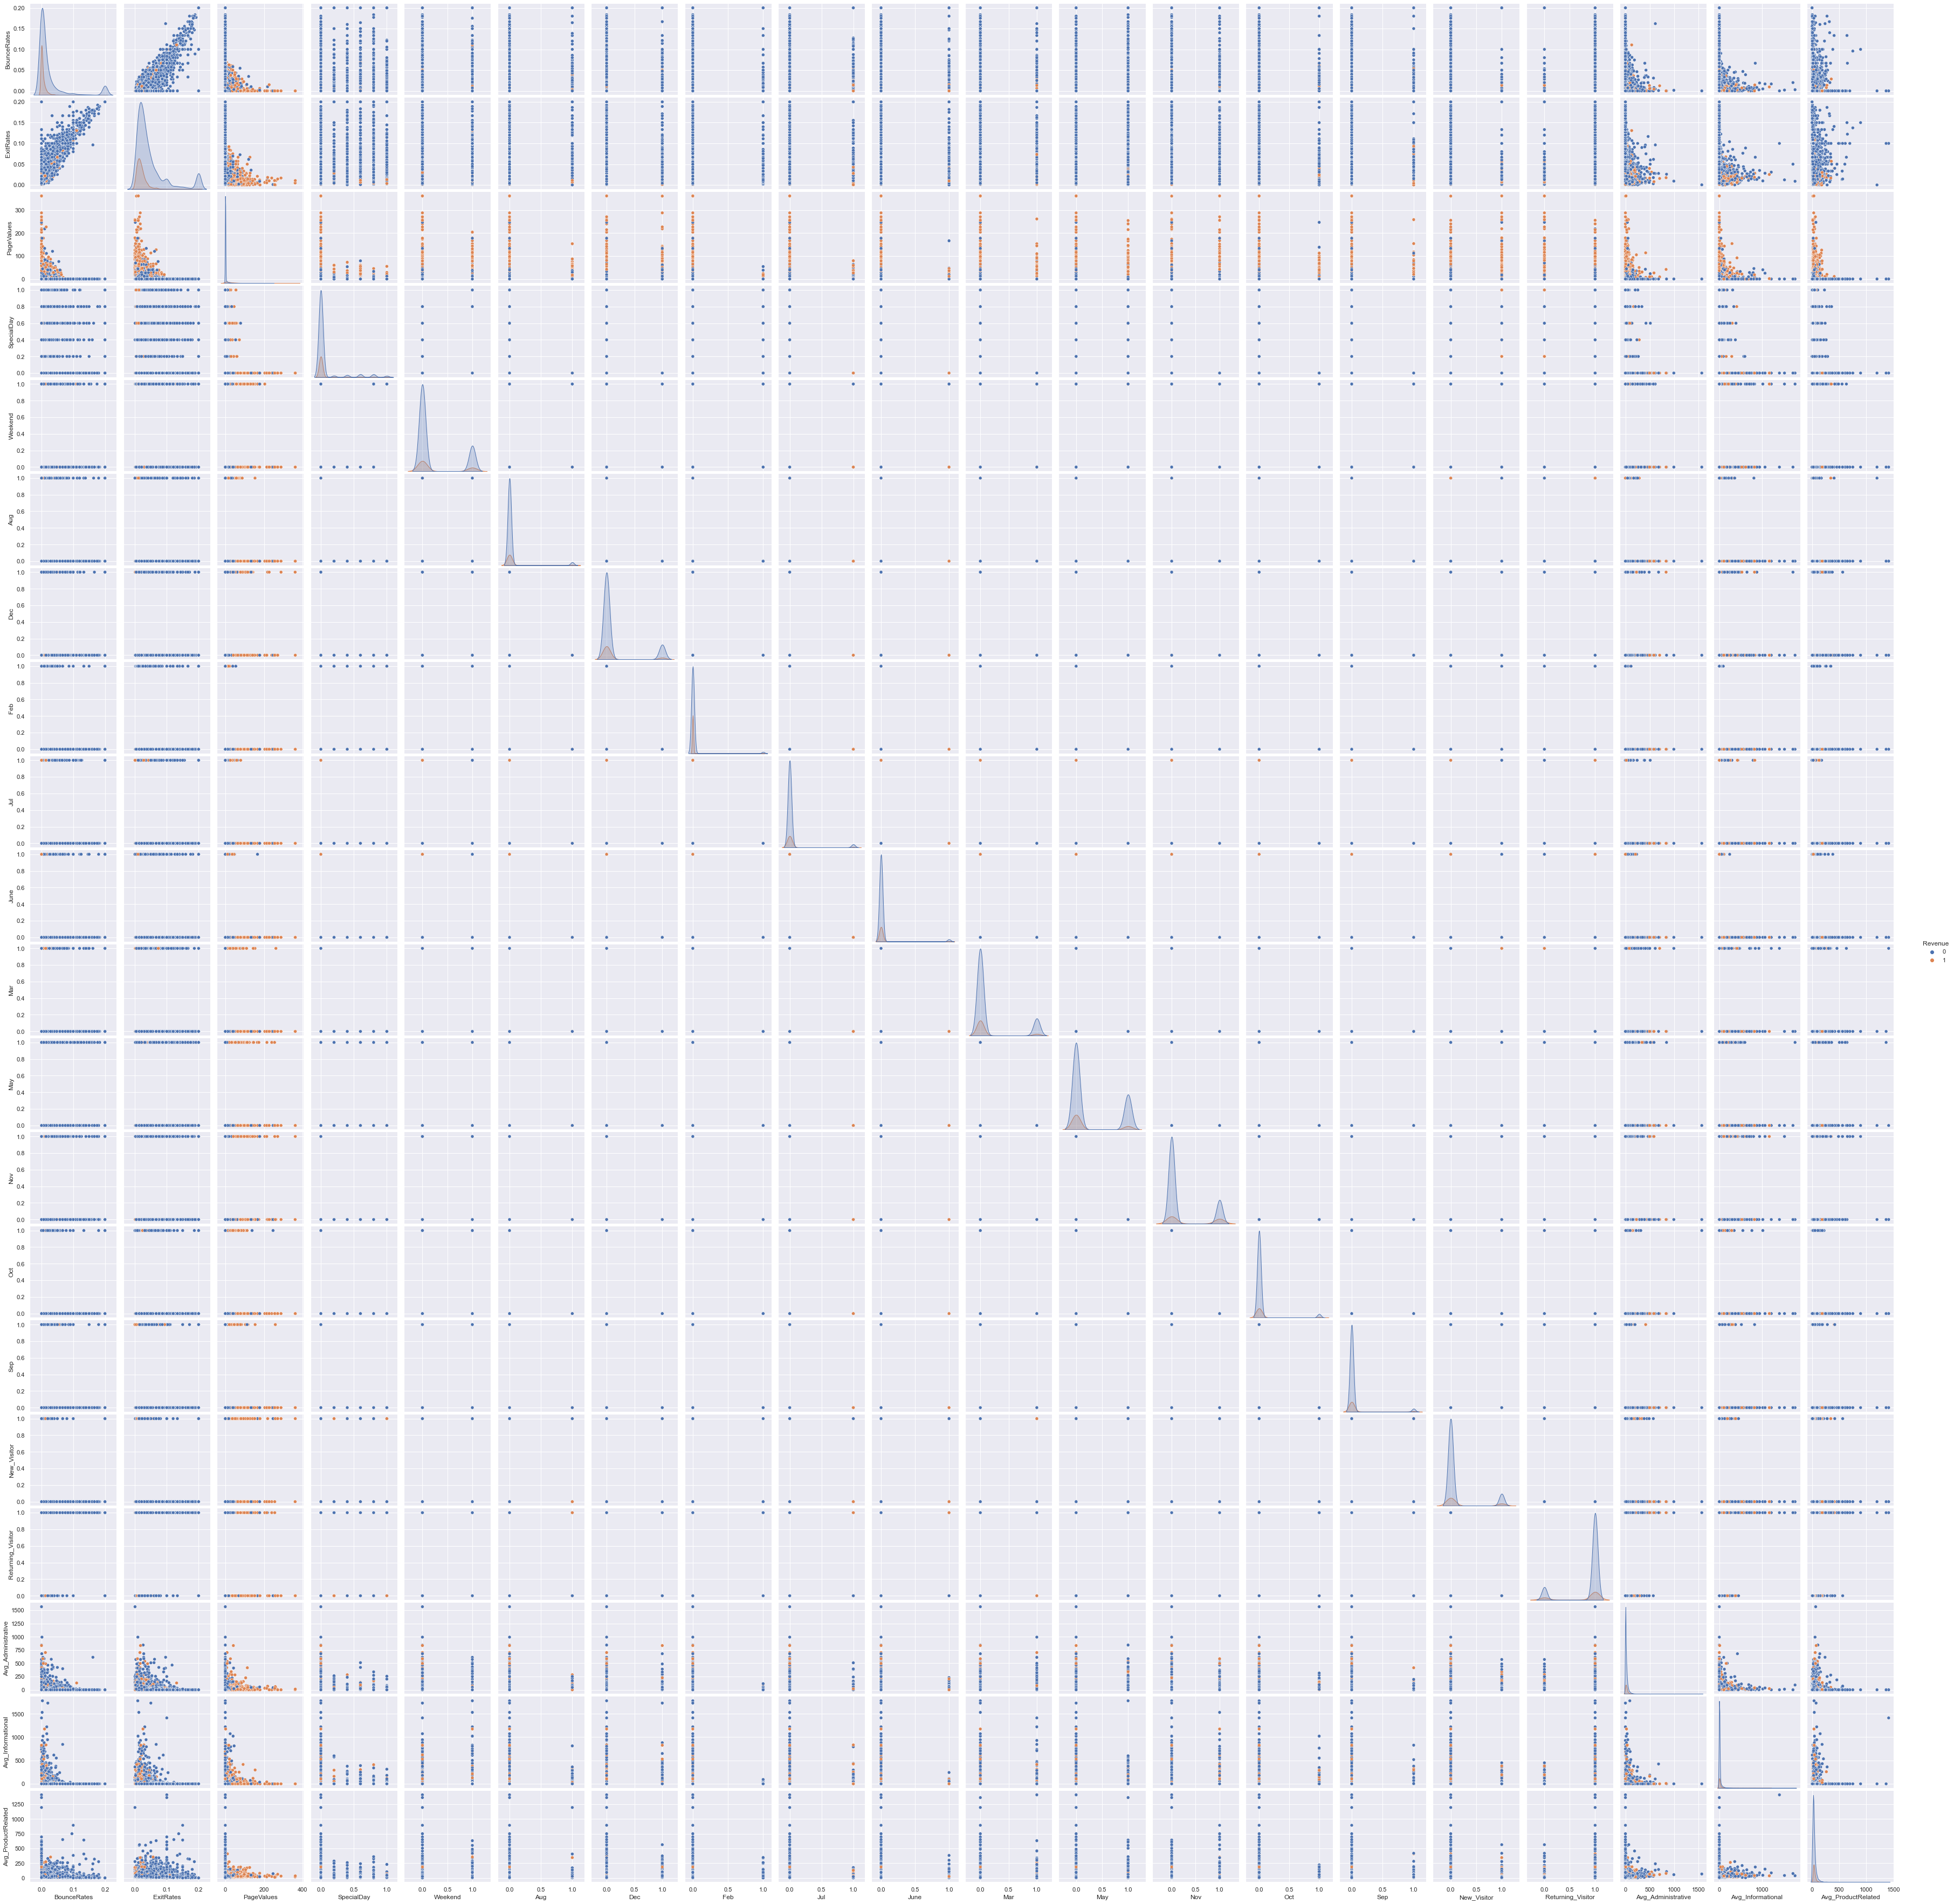

In [5]:
sns.pairplot(df, hue='Revenue')

## Look at correlations and collinearity

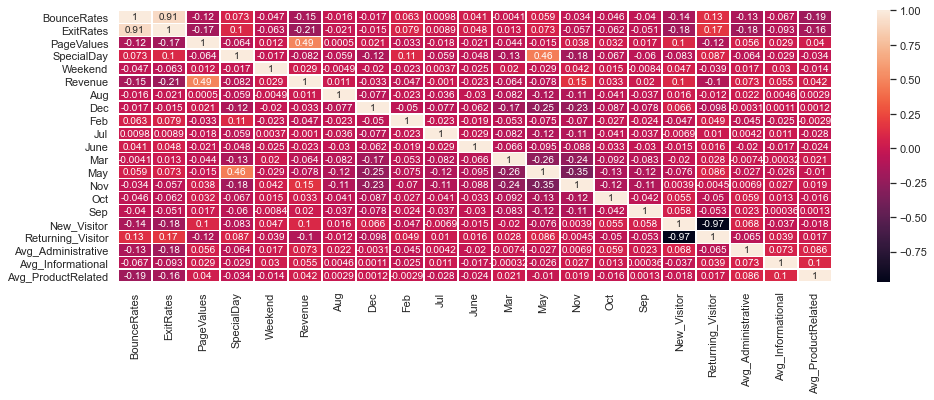

In [6]:
plt.figure(figsize = (16,5))

ax = sns.heatmap(df.corr(), annot=True, linewidths=.5)

<AxesSubplot:>

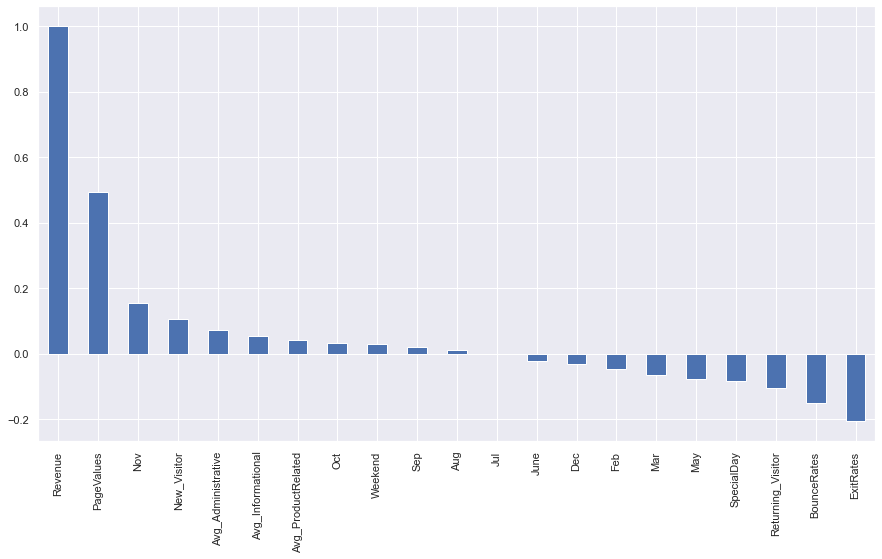

In [7]:
plt.figure(figsize=(15,8))
df.corr()['Revenue'].sort_values(ascending = False).plot(kind='bar')

For our baseline models, let's select a handful of features that are correlated with "Revenue"
- PageValues
- Nov
- New_Visitor
- ExitRates
- Avg_Administrative
- Avg_Informational
- Avg_ProductRelated

## Inspect Target Distribution

In [83]:
df['Revenue'].value_counts(normalize=True)

0    0.845255
1    0.154745
Name: Revenue, dtype: float64

The target is quite imbalanced, so we will have to address this.

## Train/test, split & Standardize the Data

In [15]:
baseline_feature_cols = ['PageValues', 'Nov', 'New_Visitor', 'ExitRates', 'Avg_Administrative',
                         'Avg_Informational', 'Avg_ProductRelated']

X = df[baseline_feature_cols].copy()
y = df['Revenue'].values

In [16]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have similar proportions of either target class
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [17]:
# Standardize the data

scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

## Create baseline models using different algorithms on select handful of features

### Baseline: Logistic Regression

In [20]:
# Instantiate model
logreg = LogisticRegression(solver='liblinear')

# Fit model to the training data
logreg.fit(X_train_scaled, y_train)

LogisticRegression(solver='liblinear')

**Note:** Since we standardized the feature data, we don't have to set a high regularization (C parameter) for the logistic regression estimator. Default regularization is okay.

In [52]:
scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}

In [53]:
results = cross_validate(logreg, X_train_scaled, y_train, cv=5, scoring=scoring)

In [54]:
for metric_name in results.keys():
    average_score = np.average(results[metric_name])
    print("Metric:", metric_name)
    print("Scores:", results[metric_name])
    print("Average score:", average_score)
    print(" ")

Metric: fit_time
Scores: [0.01730084 0.01936364 0.01564002 0.01246691 0.0129931 ]
Average score: 0.015552902221679687
 
Metric: score_time
Scores: [0.00524306 0.00403929 0.00570488 0.00417805 0.0038259 ]
Average score: 0.004598236083984375
 
Metric: test_LogLoss
Scores: [4.00882543 3.65870829 3.86877241 4.25390869 3.76565117]
Average score: 3.91117319933321
 
Metric: test_ROC AUC
Scores: [0.67951311 0.70292291 0.66851535 0.66830948 0.69308073]
Average score: 0.6824683147056003
 


Later we should address class imbalance.

## Baseline: KNN

In [55]:
# Instantiate Model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit Model
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [56]:
scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}

results = cross_validate(knn, X_train_scaled, y_train, cv=5, scoring=scoring)

for metric_name in results.keys():
    average_score = np.average(results[metric_name])
    print("Metric:", metric_name)
    print("Scores:", results[metric_name])
    print("Average score:", average_score)
    print(" ")

Metric: fit_time
Scores: [0.01768899 0.01262999 0.02147031 0.01232791 0.01299715]
Average score: 0.015422868728637695
 
Metric: score_time
Scores: [0.11862803 0.09273219 0.10107875 0.09287405 0.09395504]
Average score: 0.09985361099243165
 
Metric: test_LogLoss
Scores: [3.78126167 3.62371347 4.02634817 3.93881959 3.94081778]
Average score: 3.862192136153344
 
Metric: test_ROC AUC
Scores: [0.73565377 0.76112454 0.7341363  0.74307884 0.7449969 ]
Average score: 0.7437980700088958
 


#### Search for best n_neighbors

In [35]:
k_range = list(range(1, 100))
param_grid = dict(n_neighbors=k_range)

# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring=roc_auc)

# fit the grid with data
grid.fit(X_train_scaled, y_train);

In [36]:
# view the complete results
df_cv = pd.DataFrame(grid.cv_results_)
df_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017647,0.004471,0.043666,0.006219,1,{'n_neighbors': 1},0.712336,0.736140,0.754820,0.748883,0.719685,0.727171,0.724773,0.713721,0.697679,0.718888,0.725410,0.016390,15
1,0.018139,0.004897,0.048272,0.006074,2,{'n_neighbors': 2},0.674884,0.684688,0.695361,0.687956,0.663243,0.662044,0.664734,0.661153,0.653728,0.663265,0.671106,0.013107,99
2,0.016570,0.003468,0.046093,0.001740,3,{'n_neighbors': 3},0.734789,0.740126,0.753468,0.758863,0.757115,0.744541,0.729892,0.742758,0.742097,0.721088,0.742474,0.011351,3
3,0.016988,0.003733,0.047390,0.002018,4,{'n_neighbors': 4},0.696560,0.696560,0.713770,0.709632,0.725743,0.687161,0.705115,0.699427,0.702414,0.692944,0.702933,0.010629,98
4,0.016374,0.003409,0.048794,0.001942,5,{'n_neighbors': 5},0.731521,0.750858,0.766869,0.762461,0.758023,0.719440,0.749046,0.752335,0.751967,0.739229,0.748175,0.013687,1


In [37]:
# examine the best model
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'n_neighbors': 5}
Best estimator:  KNeighborsClassifier()
Best score:  0.7481748000222429


Funnily enough, the best knn model is the one we already trained with 5 neighbors.

## Baseline: Decision Tree

In [38]:
# Instantiate Model
dt = DecisionTreeClassifier()

In [84]:
# parameters to optimize for roc auc
criterion_options = ['gini', 'entropy']
max_depth_options = list(range(5, 21)) # 5 to 20
min_samples_split_options = list(range(2,11)) # 2 to 10
min_samples_leaf_options = list(range(1, 6)) # 1 to 5

# set metric to be optimized
roc_auc = make_scorer(roc_auc_score)

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(criterion=criterion_options,
                  max_depth=max_depth_options,
                  min_samples_split=min_samples_split_options,
                  min_samples_leaf=min_samples_leaf_options)

print(param_grid)

{'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5]}


In [42]:
# instantiate and fit the grid on training data
grid = GridSearchCV(dt, param_grid, cv=10, scoring=roc_auc)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                       16, 17, 18, 19, 20],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring=make_scorer(roc_auc_score))

The above cell was computationally time-consuming.

In [43]:
df_cv = pd.DataFrame(grid.cv_results_)
df_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016823,0.004292,0.003101,0.000799,gini,5,1,2,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.744922,...,0.816218,0.775085,0.712877,0.742175,0.73827,0.776911,0.738362,0.759103,0.029045,244
1,0.014547,0.000222,0.002700,0.000084,gini,5,1,3,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.744922,...,0.816218,0.775085,0.712877,0.742175,0.73827,0.776911,0.738362,0.759163,0.029113,241
2,0.014474,0.000275,0.002725,0.000133,gini,5,1,4,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.744922,...,0.816218,0.775085,0.709588,0.742175,0.73827,0.776911,0.738362,0.758774,0.029580,257
3,0.014548,0.000196,0.002770,0.000263,gini,5,1,5,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.744922,...,0.828090,0.775085,0.709588,0.742175,0.73827,0.776911,0.738362,0.760021,0.032062,214
4,0.014530,0.000164,0.002776,0.000192,gini,5,1,6,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.744922,...,0.828090,0.775085,0.712877,0.742175,0.73827,0.776911,0.738362,0.760290,0.031494,204


In [57]:
# examine the best model
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 6}
Best estimator:  DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=6)
Best score:  0.7701889587716949


#### Fit and score a new dt model with best parameters

In [59]:
# Instantiate Model
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=6)

# Fit Model
dt.fit(X_train, y_train)

# Score Model
scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}

results = cross_validate(dt, X_train, y_train, cv=5, scoring=scoring)

for metric_name in results.keys():
    average_score = np.average(results[metric_name])
    print("Metric:", metric_name)
    print("Scores:", results[metric_name])
    print("Average score:", average_score)
    print(" ")

Metric: fit_time
Scores: [0.02385521 0.01822591 0.01577592 0.01488996 0.01646304]
Average score: 0.01784200668334961
 
Metric: score_time
Scores: [0.00556278 0.00537515 0.0042491  0.00387311 0.00391197]
Average score: 0.00459442138671875
 
Metric: test_LogLoss
Scores: [3.78126289 3.44865794 3.53617963 3.88630366 3.78318685]
Average score: 3.687118193259599
 
Metric: test_ROC AUC
Scores: [0.73967252 0.78287632 0.75190667 0.75198294 0.7610904 ]
Average score: 0.7575057718338002
 


LogLoss and ROC AUC slightly better than knn model's.

## Baseline: Random Forest

In [61]:
# Instantiate Model
rf = RandomForestClassifier(n_estimators=100)

In [62]:
# parameters to optimize for roc auc
criterion_options = ['gini', 'entropy']
max_depth_options = list(range(5, 21)) # 5 to 20
max_features_options = ['auto', 'sqrt', 'log2']

# set metric to be optimized
roc_auc = make_scorer(roc_auc_score)

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(criterion=criterion_options,
                 max_depth=max_depth_options,
                 max_features=max_features_options)

print(param_grid)

{'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_features': ['auto', 'sqrt', 'log2']}


In [66]:
# instantiate and fit the grid
grid = GridSearchCV(rf, param_grid, cv=10, scoring=roc_auc)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                       16, 17, 18, 19, 20],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring=make_scorer(roc_auc_score))

In [67]:
df_cv = pd.DataFrame(grid.cv_results_)
df_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.448559,0.055702,0.019016,0.001414,gini,5,auto,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.747320,0.752386,...,0.791602,0.783463,0.717965,0.738885,0.744265,0.787648,0.752034,0.759524,0.023326,92
1,0.531729,0.072684,0.024297,0.007347,gini,5,sqrt,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.754455,0.764259,...,0.789533,0.780773,0.719764,0.738286,0.738286,0.785047,0.754702,0.760391,0.022185,91
2,0.437055,0.028892,0.018628,0.000701,gini,5,log2,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.760392,0.768997,...,0.786865,0.785261,0.714076,0.726327,0.746356,0.781112,0.742497,0.757020,0.023529,93
3,0.461939,0.005018,0.019597,0.001509,gini,6,auto,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.753256,0.760392,...,0.795470,0.780173,0.723345,0.759513,0.747555,0.784714,0.750834,0.763285,0.020263,89
4,0.466821,0.009081,0.019263,0.000459,gini,6,sqrt,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.755055,0.761861,...,0.796939,0.786153,0.718856,0.752335,0.744265,0.782313,0.762105,0.764909,0.022781,87


In [68]:
# examine the best model
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt'}
Best estimator:  RandomForestClassifier(max_depth=10, max_features='sqrt')
Best score:  0.7766866553512733


#### Fit and score a new rf model with best parameters

In [69]:
# Instantiate Model
rf = RandomForestClassifier(max_depth=10, max_features='sqrt')

# Fit Model
rf.fit(X_train, y_train)

# Score Model
scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}

results = cross_validate(rf, X_train, y_train, cv=5, scoring=scoring)

for metric_name in results.keys():
    average_score = np.average(results[metric_name])
    print("Metric:", metric_name)
    print("Scores:", results[metric_name])
    print("Average score:", average_score)
    print(" ")

Metric: fit_time
Scores: [0.59442902 0.59235978 0.54064608 0.55180478 0.5527482 ]
Average score: 0.5663975715637207
 
Metric: score_time
Scores: [0.034127   0.03264499 0.03231502 0.03344512 0.03187704]
Average score: 0.03288183212280273
 
Metric: test_LogLoss
Scores: [3.64121838 3.02851186 3.27359228 3.9213159  3.50295094]
Average score: 3.473517870387537
 
Metric: test_ROC AUC
Scores: [0.75680603 0.79274973 0.7711385  0.75138306 0.77928349]
Average score: 0.7702721617094987
 


Log loss and ROC AUC scores better than decision tree.

## Possible Future Steps

- try an XGBoost baseline model after installing properly
- try decision tree with bagging
- compare again and consider moving forward with decision tree or logistic regression pending seeing other baselines
- try logistic regression with different thresholds
- try using weights for imbalance

## Baseline: XGBoost

In [71]:
# Instantiate Model
xgb = XGBClassifier()

# Fit Model
xgb.fit(X_train, y_train)

[21:34:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [72]:
# Score Model
scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}

results = cross_validate(xgb, X_train, y_train, cv=5, scoring=scoring)

for metric_name in results.keys():
    average_score = np.average(results[metric_name])
    print("Metric:", metric_name)
    print("Scores:", results[metric_name])
    print("Average score:", average_score)
    print(" ")

/Users/varshagarla/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/varshagarla/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/varshagarla/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/varshagarla/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/varshagarla/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Metric: fit_time
Scores: [0.71982002 0.78608608 0.66079593 0.67367411 0.83542609]
Average score: 0.7351604461669922
 
Metric: score_time
Scores: [0.01299787 0.00713682 0.00710011 0.00710082 0.00875473]
Average score: 0.00861806869506836
 
Metric: test_LogLoss
Scores: [3.53618287 3.48367059 3.60620776 4.11388242 3.53797891]
Average score: 3.655584508237337
 
Metric: test_ROC AUC
Scores: [0.76262334 0.78361639 0.76276389 0.74541562 0.77198659]
Average score: 0.7652811651651618
 


LogLoss not better than random forest and ROC AUC only marginally better than random forest.

## Note on model selection from baseline models

As per the project design, the e-commerce company will offer a coupon to any online shoppers who might make a purchase, meaning the model predicted their probability of purchasing to be 0.3 < p <. 0.7.

Considering this, we don't merely care about the hard predictions (class labels of "will purchase" and "won't purchase"). We care about the probabilities output by the model.

**Decision Tree**
A decision tree does not provide reliable probabilities. As the documentation says, the way it generates probabilities is the number of samples of a given class on a given leaf, over the number of samples in that leaf.

**Random Forest**
While random forest probabilities are more stable than the decision tree's, random forest is not interpretable and our e-commerce client cares about interpretability to understand how the features should affect promotions in order to increase the website's purchase conversion rates.

**XGBoost**
XGBoost tends to predict probabilities conservatively, meaning closer to mid-range than to extremes. Furthermore, it is more of a black box model and difficult to interpret.

**KNN**
KNN has very limited concept of probability. Its estimate is simply the fraction of votes among nearest neighbors.

**Logistic Regression**
While the logistic regression had the worst performance of the baseline models in terms of ROC AUC and log loss, logistic regression optimizes for the log-loss directly, so it's probabilities are generally well calibrated. We can easily obtain them using .predict_proba. Additionally, it is interpretable via the coefficients of the features.

### Select logistic regression model and tune it

... in the next notebook!

But before we go...

#### Let's look at the feature importances from random forest model out of curiosity before moving onto our logistic regression model

In [77]:
# Feature importance

rf_feats = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

rf_feats

,feature,importance
0,PageValues,0.607246
3,ExitRates,0.123672
6,Avg_ProductRelated,0.090978
4,Avg_Administrative,0.084630
5,Avg_Informational,0.041543
1,Nov,0.031142
2,New_Visitor,0.020788


## Let's train a random forest model with the best parameters, but this time on all features in dataset and see the feature importance for curiosity's sake

In [79]:
# New X dataframe with all features in dataset
X_all = df.drop('Revenue', axis=1)

# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have similar proportions of either target class
X_all_train, X_all_test, y_train, y_test = train_test_split(X_all,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [80]:
# Instantiate Model
rf = RandomForestClassifier(max_depth=10, max_features='sqrt')

# Fit Model on training data with all features
rf.fit(X_all_train, y_train)

# Score Model
scoring = {'LogLoss' : make_scorer(log_loss),
          'ROC AUC' : make_scorer(roc_auc_score)}

results = cross_validate(rf, X_all_train, y_train, cv=5, scoring=scoring)

for metric_name in results.keys():
    average_score = np.average(results[metric_name])
    print("Metric:", metric_name)
    print("Scores:", results[metric_name])
    print("Average score:", average_score)
    print(" ")

Metric: fit_time
Scores: [0.54591203 0.54461598 0.54521775 0.53579926 0.55434871]
Average score: 0.545178747177124
 
Metric: score_time
Scores: [0.03727579 0.0322361  0.03300929 0.03220677 0.03140807]
Average score: 0.03322720527648926
 
Metric: test_LogLoss
Scores: [3.53617922 3.11603841 3.16855231 3.53618165 3.31028353]
Average score: 3.333447024424069
 
Metric: test_ROC AUC
Scores: [0.75056709 0.77785509 0.76222039 0.75931578 0.7745464 ]
Average score: 0.7649009508019795
 


Interestingly, this performed better than the random forest model trained on a handful of features

#### Now let's look at the feature importance from this random forest that used all features in the dataset

In [82]:
# Feature importance

rf_feats = pd.DataFrame({
    'feature': X_all.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

rf_feats

,feature,importance
2,PageValues,0.586638
1,ExitRates,0.094965
0,BounceRates,0.068109
19,Avg_ProductRelated,0.065634
17,Avg_Administrative,0.061952
18,Avg_Informational,0.032723
12,Nov,0.024669
15,New_Visitor,0.010788
16,Returning_Visitor,0.010628
4,Weekend,0.007321


For the logistic regression, we will perform feature selection using different combinations of features:
    i.e. handful, all, etc.
    
We will probably only pick one of the pairs of features that are collinear, so that the coefficients are representative of importance. For example, we will probably only include ExitRates or BounceRates, and New_Visitor or Returning_Visitor. Maybe we can include Weekend, May, Mar, and SpecialDay too.